<a href="https://colab.research.google.com/github/gnomez1208/gnomez1208/blob/Dark-Matter-Research/LDR_waveform_filtering%231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install uproot

from google.colab import files

print("Please select 'output03048.root' from your Ubuntu machine.")
uploaded = files.upload()
#saved onto google colab local file environment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.8/383.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 14.1 MB/s eta 0:00:00
Please select 'output03048.root' from your Ubuntu machine.


Saving output03048.root to output03048.root


#**Creating the Waveform**
- baseline subtraction
  - check its working properly on the raw waveform
- want a moving average fit
  - including a low and high pass filter with
  - watch out for the bounds and dataframe lengths

In [14]:
import uproot
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter, filtfilt
import plotly.graph_objects as go

'''
-----------things to note from MIDAS-----------
y axis - ADC counts per 4ns
- most if not all in range of 7000-8000 (wide)
- tigher range could be 7200 - 7600
x axis - time in ns (window for each waveform is 5000 ns)

'''



def butter_highpass_filter(data, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    print(f"High-pass filter: cutoff={cutoff}, fs={fs}, nyq={nyq}, normal_cutoff={normal_cutoff}")
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    print(f"Low-pass filter: cutoff={cutoff}, fs={fs}, nyq={nyq}, normal_cutoff={normal_cutoff}")
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)


def moving_average_filter(data, window_size):
    """
    Applies a moving average filter to the data. Be careful with bounds!
    Ended up needing to add a filtfilt function so that the df values length were conserved
    """
    a = 1
    b = np.ones(window_size) / window_size

    return filtfilt(b, a, data)

## Make a Dataframe with Filters


In [38]:
file_path = "/content/output03048.root"

#  1. DEFINING EXPERIMENTAL PARAMETERS
# ==============================================================================
sampling_period_ns = 4
integration_window_ns = 250
pre_trigger_ns = 200
pre_trigger_samples = int(pre_trigger_ns / sampling_period_ns)
sampling_frequency = 1 / (sampling_period_ns * 1e-9) # In Hz

# --- Select and load a single waveform ---
waveform_index_to_plot = 709

with uproot.open(file_path) as file:
    key = file.keys()[waveform_index_to_plot]
    waveform_np = file[key].values()

# --- Create the initial DataFrame ---
time_ns = np.arange(len(waveform_np)) * sampling_period_ns
df = pd.DataFrame({'Time (ns)': time_ns, 'Raw ADC': waveform_np})

# --- Perform baseline subtraction ---
baseline = df['Raw ADC'][:pre_trigger_samples].mean()
df['Baseline Subtracted'] = df['Raw ADC'] - baseline

# --- Apply filters and add them as new columns to the DataFrame ---
print("Applying filters...")

# Apply a high-pass filter
df['High-Pass'] = butter_highpass_filter(df['Baseline Subtracted'], cutoff=1e6, fs=sampling_frequency)

# Apply a low-pass filter
df['Low-Pass'] = butter_lowpass_filter(df['Baseline Subtracted'], cutoff=10e6, fs=sampling_frequency)

# Create a band-pass filter by applying the low-pass to the high-passed signal
df['Band-Pass'] = butter_lowpass_filter(df['High-Pass'], cutoff=10e6, fs=sampling_frequency)

# Apply the zero-phase moving average filter
df['Moving Average'] = moving_average_filter(df['Baseline Subtracted'], window_size=12)

print("\n--- DataFrame with all filtered data ---")
display(df.head())

Applying filters...
High-pass filter: cutoff=1000000.0, fs=249999999.99999997, nyq=124999999.99999999, normal_cutoff=0.008
Low-pass filter: cutoff=10000000.0, fs=249999999.99999997, nyq=124999999.99999999, normal_cutoff=0.08000000000000002
Low-pass filter: cutoff=10000000.0, fs=249999999.99999997, nyq=124999999.99999999, normal_cutoff=0.08000000000000002

--- DataFrame with all filtered data ---


,Time (ns),Raw ADC,Baseline Subtracted,High-Pass,Low-Pass,Band-Pass,Moving Average
0,0,7462.0,-9.759766,16.017088,-8.210538,17.667000,-9.759766
1,4,7469.0,-2.759766,22.624112,-2.821616,22.665976,-4.877821
2,8,7479.0,7.240234,32.233635,2.407745,27.501689,-0.155599
3,12,7486.0,14.240234,38.845912,7.344058,32.042942,4.288845
4,16,7485.0,13.240234,37.461190,11.868264,36.172562,8.337457


## Let's create the waveform

###Check Baseline First

In [39]:
# Plotting ONLY the Raw Waveform and its calculated baseline

# Create a new figure for the raw plot
fig_raw = go.Figure()

# Add the raw waveform trace
fig_raw.add_trace(go.Scatter(
    x=df['Time (ns)'],
    y=df['Raw ADC'],
    name='Raw Waveform',
    mode='lines',
    line=dict(color='darkslateblue')
))

# Add the horizontal baseline for the RAW data
# Use the 'baseline' variable which holds the actual mean ADC value of the pre-trigger region (e.g., ~7500).
fig_raw.add_hline(
    y=baseline,
    line_dash="dash",
    annotation_text=f"Calculated Baseline ({baseline:.2f})",
    annotation_position="bottom right",
    line_color="red",
    line_width=2
)

# Update layout for the raw plot
fig_raw.update_layout(
    title_text=f"Raw Waveform and Calculated Baseline (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)",
    yaxis_title="Raw ADC Value",
    hovermode="x"
)

fig_raw.show()

In [40]:
# Cell 3: Corrected Baseline & Noise Diagnostic Plots

# --- 1. Analyze the UNFILTERED pre-trigger region ---
unfiltered_pre_trigger_data = df['Baseline Subtracted'][:pre_trigger_samples]
unfiltered_noise_sigma = unfiltered_pre_trigger_data.std()

# --- 2. Analyze the FILTERED pre-trigger region ---
# We use .dropna() in case the first few values are NaN from filtering
filtered_pre_trigger_data = df['Moving Average'].dropna()[:pre_trigger_samples]
filtered_noise_sigma = filtered_pre_trigger_data.std() # This is the value we need!

print(f"--- Noise Analysis ---")
print(f"Unfiltered Noise Level (σ_raw): {unfiltered_noise_sigma:.2f} ADC counts")
print(f"Filtered Noise Level (σ_filt): {filtered_noise_sigma:.2f} ADC counts")
print(f"-> The filter reduced the noise by a factor of {unfiltered_noise_sigma/filtered_noise_sigma:.1f}x")


# --- Diagnostic Plot 1: Pre-trigger Histogram (This plot remains the same) ---
fig_hist = go.Figure()
fig_hist.add_trace(go.Histogram(x=unfiltered_pre_trigger_data, name='Pre-trigger Noise'))
fig_hist.update_layout(
    title_text="<b>Diagnostic 1:</b> Histogram of Unfiltered Pre-Trigger Noise",
    xaxis_title="ADC Counts (after baseline subtraction)",
    yaxis_title="Frequency"
)
fig_hist.show()


# --- Diagnostic Plot 2: Zoomed-in view using CORRECTED noise level ---
fig_zoom = go.Figure()

# Plot the moving average trace for the pre-trigger region
fig_zoom.add_trace(go.Scatter(
    x=df['Time (ns)'][:pre_trigger_samples],
    y=df['Moving Average'][:pre_trigger_samples],
    name='Filtered Waveform (Noise)',
    mode='lines',
    line=dict(color='crimson')
))

# Add lines showing the CORRECT, filtered noise level (+/- 3σ)
fig_zoom.add_hline(y=3 * filtered_noise_sigma, line_dash="dash", line_color="orange", annotation_text="3σ (Filtered)")
fig_zoom.add_hline(y=-3 * filtered_noise_sigma, line_dash="dash", line_color="orange")
fig_zoom.add_hline(y=0, line_color="black") # Zero line

fig_zoom.update_layout(
    title_text="<b>Diagnostic 2:</b> Zoomed-in View of Filtered Noise",
    xaxis_title="Time (ns)",
    yaxis_title="Filtered ADC Value"
)
fig_zoom.show()

--- Noise Analysis ---
Unfiltered Noise Level (σ_raw): 20.72 ADC counts
Filtered Noise Level (σ_filt): 11.71 ADC counts
-> The filter reduced the noise by a factor of 1.8x


## Need to fix noise after filtering, was still too high after baseline diagnostic

-

In [41]:
#

In [42]:
# Plot the comparison
# Get Peaks

peaks_base, _ = find_peaks(-df['Baseline Subtracted'], prominence=5, distance=20)
peaks_mav, _ = find_peaks(-df['Moving Average'], prominence=2, distance=20)

fig = go.Figure()

# Add the original baseline-subtracted trace
fig.add_trace(go.Scatter(
    x=df['Time (ns)'], y=df['Baseline Subtracted'],
    name='Baseline Subtracted (Original)', mode='lines',
    line=dict(color='red', width = 1.5)
))

# Add traces for each filtered waveform
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Band-Pass'], name='Band-Pass Filter', mode='lines', line=dict(width=2, color = 'green')))
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Moving Average'], name='Moving Average', mode='lines', line=dict(width=2, color = 'blue')))

fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['High-Pass'], name='High-Pass Only', mode='lines', visible='legendonly'))
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Low-Pass'], name='Low-Pass Only', mode='lines', visible='legendonly'))


#Peak Markers

# Markers for Baseline Subtracted peaks
fig.add_trace(go.Scatter(
    x=df['Time (ns)'].iloc[peaks_base], y=df['Baseline Subtracted'].iloc[peaks_base],
    name='Baseline Subtracted Peaks', mode='markers',
    marker=dict(color='red', symbol='diamond', size=8, line=dict(width=1,color = 'black') )
))

# Markers for Moving Average peaks
fig.add_trace(go.Scatter(
    x=df['Time (ns)'].iloc[peaks_mav], y=df['Moving Average'].iloc[peaks_mav],
    name='Moving Average Peaks', mode='markers',
    marker=dict(color='blue', symbol='x', size=8, line=dict(width=1))
))

# Update layout for clarity
fig.update_layout(
    title_text=f"Comparison of Zero-Phase Filters (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)",
    yaxis_title="ADC Value (Baseline Subtracted)",
    legend_title="Filter Type",
)

#Make a horizontal line to check if my baseline is actually where I want it
fig.add_hline(
    y=0,
    line_dash = 'dot',
    annotation_text = "Calculated Baseline",
    annotation_position = "bottom right",
    line_color = 'black',
    line_width = 1
)

fig.show()

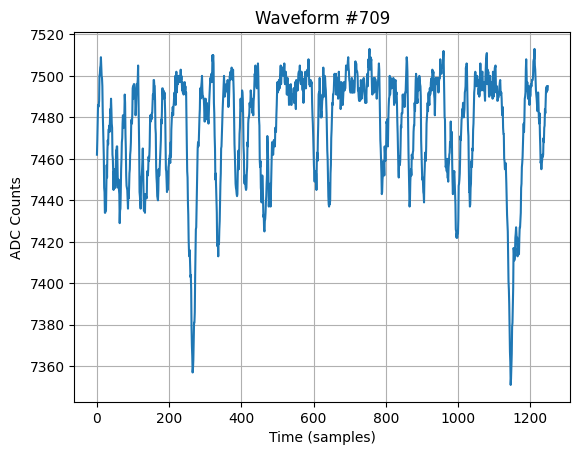

In [43]:
#======================================
# Check what waveform should look like
#======================================

import matplotlib.pyplot as plt

with uproot.open(file_path) as file:
    keys = file.keys()
    if waveform_index_to_plot < len(keys):
        wf_key = keys[waveform_index_to_plot]
        waveform_np = file[wf_key].values()
        plt.plot(waveform_np)
        plt.title(f"Waveform #{waveform_index_to_plot}")
        plt.xlabel("Time (samples)")
        plt.ylabel("ADC Counts")
        plt.grid(True)
        plt.show()
    else:
        print(f"Invalid waveform index: {waveform_index_to_plot}")

##Single Photoelectron Calibration
my approach...

- trying to measure out an spe amplitude and use it as a ruler to measure larger pulses (which should be multiples of it)
- adaptive algorithm idea
  - find all peaks rising from the baseline
  - get their heights and make a histogram
  - assuming the first distinct peak from zero will be our spe peak, get the amplitude
  - draw a horizontal line of that amplitude onto our interactive plot


In [44]:
# Find all peaks in filtered waveform

all_peaks, properties = find_peaks(
    -df['Moving Average'].dropna(),
    prominence=1 #lower prom to find smallest peaks w/out noise
)

peak_heights = properties['prominences']

# Create histogram
if len(peak_heights) > 10:
  counts, bin_edges = np.histogram(peak_heights, bins=100, range=(0,20))
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#start at some nonzero bin to avoid noise peak at zero
  start_bin_index = 5
#find bin with most counts after noise region
  spe_bin_index = np.argmax(counts[start_bin_index:]) + start_bin_index
#estimated spe peak should be the center of this bin
  spe_peak_height = bin_centers[spe_bin_index]

  print(f'Found {len(peak_heights)} peaks in waveform {waveform_index_to_plot}.')
  print(f'Estimated SPE Peak Height: {spe_peak_height:.2f}')

else:
  spe_peak_height = None
  print(f"Not enough peaks found in this waveform to estimate SPE peak height.")

Found 29 peaks in waveform 709.
Estimated SPE Peak Height: 1.70


In [45]:
# Plot with Adaptive SPE Levels


fig = go.Figure()

# Plotting the baseline-subtracted and moving average traces
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Baseline Subtracted'], name='Baseline Subtracted', mode='lines', line=dict(color='rgba(70, 130, 180, 0.6)', width=2)))
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Moving Average'], name='Moving Average', mode='lines', line=dict(color='crimson', width=2.5)))

# Adaptive SPE Lines
if spe_peak_height is not None:
    # Draw a line for the 1 PE level
    fig.add_hline(y=-spe_peak_height, line_dash="solid", line_color="springgreen", line_width=3,
                  annotation_text="1 PE", annotation_position="bottom right")

    # Draw dashed lines for 2 PE and 3 PE levels
    fig.add_hline(y=-2 * spe_peak_height, line_dash="dash", line_color="gold", line_width=2,
                  annotation_text="2 PE", annotation_position="bottom right")

    fig.add_hline(y=-3 * spe_peak_height, line_dash="dash", line_color="orange", line_width=2,
                  annotation_text="3 PE", annotation_position="bottom right")

#   #Add baseline
# fig.add_hline(
#     y=baseline,
#     line_dash="dash",
#     annotation_text=f"Calculated Baseline ({baseline:.2f})",
#     annotation_position="bottom right",
#     line_color="red",
#     line_width=2
#)

# Update Layout
fig.update_layout(
    title_text=f"Waveform with Adaptive SPE Peaks (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)",
    yaxis_title="ADC Value",
    legend_title="Trace Type",
    hovermode="x unified",
    yaxis=dict(
        autorange='reversed'  # Flip the y-axis
    )
)

fig.show()



waveform 809 looks promising

## Charge Integration for SPE Peak Finder

In [ ]:
# Cell 4: Charge-Based SPE Finder

# --- 1. Find all peaks using the adaptive prominence threshold ---
# We still use prominence to LOCATE the peaks.
adaptive_prominence = 3 * filtered_noise_sigma
all_peaks, _ = find_peaks(
    -df['Moving Average'].dropna(),
    prominence=adaptive_prominence
)

# --- 2. Calculate the CHARGE for each found peak ---
peak_charges = []
charge_integration_window = 10 # Integrate +/- 5 samples around the peak

for peak_loc in all_peaks:
    # Define the integration window for this specific peak
    start = max(0, peak_loc - charge_integration_window // 2)
    end = min(len(df), peak_loc + charge_integration_window // 2)

    # Calculate charge by summing the inverted ADC counts in the window
    # We use the baseline-subtracted data for a more accurate charge value.
    charge = -df['Baseline Subtracted'][start:end].sum()
    peak_charges.append(charge)

peak_charges = np.array(peak_charges) # Convert to numpy array

# --- 3. Find the SPE Charge from a histogram ---
if len(peak_charges) > 5:
    # You may need to adjust the 'range' based on your expected charge values
    counts, bin_edges = np.histogram(peak_charges, bins=100, range=(0, 2000))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Find the bin with the most counts to estimate the SPE charge
    spe_charge_bin_index = np.argmax(counts)
    spe_charge_estimate = bin_centers[spe_charge_bin_index]

    print(f"✅ Found {len(peak_charges)} significant peaks.")
    print(f"   Estimated Single Photoelectron (SPE) Charge: {spe_charge_estimate:.2f} (integrated ADC counts)")
else:
    spe_charge_estimate = None
    print(f"⚠️ Not enough significant peaks found to estimate SPE charge.")

In [ ]:
# Cell 5: Plotting the Charge Histogram and Waveform with SPE Charge Levels

# --- Plot 1: The Charge Histogram ---
if spe_charge_estimate is not None:
    fig_charge_hist = go.Figure()
    fig_charge_hist.add_trace(go.Bar(x=bin_centers, y=counts, name='Peak Charge Distribution'))

    # Add a line showing where the SPE charge was estimated
    fig_charge_hist.add_vline(x=spe_charge_estimate, line_dash="dash", line_color="red",
                              annotation_text=f"SPE Charge ≈ {spe_charge_estimate:.0f}")

    fig_charge_hist.update_layout(
        title_text="<b>Diagnostic:</b> Histogram of Peak Charges",
        xaxis_title="Peak Charge (Integrated ADC Counts)",
        yaxis_title="Frequency"
    )
    fig_charge_hist.show()


# --- Plot 2: The Waveform with SPE Charge Levels ---
fig = go.Figure()

# Add Waveform Traces
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Baseline Subtracted'], name='Baseline Subtracted', mode='lines', line=dict(color='rgba(70, 130, 180, 0.6)', width=2)))
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Moving Average'], name='Moving Average', mode='lines', line=dict(color='crimson', width=2.5)))

# Add horizontal lines based on the estimated SPE *height* for visual reference
if spe_peak_height is not None:
    fig.add_hline(y=-spe_peak_height, line_dash="solid", line_color="springgreen",
                  annotation_text="1 PE (by Height)", annotation_position="bottom right")
    fig.add_hline(y=-2 * spe_peak_height, line_dash="dash", line_color="gold",
                  annotation_text="2 PE (by Height)", annotation_position="bottom right")
    fig.add_hline(y=-3 * spe_peak_height, line_dash="dash", line_color="orange",
                  annotation_text="3 PE (by Height)", annotation_position="bottom right")

fig.update_layout(
    title_text=f"Waveform with Charge-Based SPE Analysis (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)",
    yaxis_title="ADC Value",
    legend_title="Trace Type",
    hovermode="x unified",
    yaxis=dict(autorange='reversed')
)

fig.show()

In [ ]:
# Cell 5: Plotting with Peaks Labeled by Charge

# --- 1. Classify each peak based on its charge ---
# We'll create separate lists to hold the locations of each peak type.
peaks_1pe = []
peaks_2pe = []
peaks_3pe = []
peaks_other = []

if spe_charge_estimate is not None:
    # Define a tolerance window for classification (e.g., +/- 50% of the SPE charge)
    tolerance = 0.20 * spe_charge_estimate

    for i, peak_loc in enumerate(all_peaks):
        charge = peak_charges[i]

        # Check if the peak's charge falls into the 1 PE category
        if abs(charge - spe_charge_estimate) < tolerance:
            peaks_1pe.append(peak_loc)
        # Check for the 2 PE category
        elif abs(charge - 2 * spe_charge_estimate) < tolerance:
            peaks_2pe.append(peak_loc)
        # Check for the 3 PE category
        elif abs(charge - 3 * spe_charge_estimate) < tolerance:
            peaks_3pe.append(peak_loc)
        else:
            peaks_other.append(peak_loc)

    print(f"Classification complete: Found {len(peaks_1pe)} (1 PE), {len(peaks_2pe)} (2 PE), and {len(peaks_3pe)} (3 PE) peaks.")


# --- 2. Create the Final Interactive Plot ---
fig = go.Figure()

# Add the main waveform traces
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Baseline Subtracted'], name='Baseline Subtracted', mode='lines', line=dict(color='rgba(70, 130, 180, 0.6)', width=2)))
fig.add_trace(go.Scatter(x=df['Time (ns)'], y=df['Moving Average'], name='Moving Average', mode='lines', line=dict(color='crimson', width=2.5)))

# --- Add Labeled Markers for each PE category ---
# Note: .iloc is used to get values at the specific peak locations (indices)

# Markers for 1 PE peaks
fig.add_trace(go.Scatter(x=df['Time (ns)'].iloc[peaks_1pe], y=df['Moving Average'].iloc[peaks_1pe],
                         name='1 PE Peaks', mode='markers', marker=dict(color='lime', symbol='circle', size=10)))

# Markers for 2 PE peaks
fig.add_trace(go.Scatter(x=df['Time (ns)'].iloc[peaks_2pe], y=df['Moving Average'].iloc[peaks_2pe],
                         name='2 PE Peaks', mode='markers', marker=dict(color='gold', symbol='diamond', size=10)))

# Markers for 3 PE peaks
fig.add_trace(go.Scatter(x=df['Time (ns)'].iloc[peaks_3pe], y=df['Moving Average'].iloc[peaks_3pe],
                         name='3 PE Peaks', mode='markers', marker=dict(color='darkorange', symbol='square', size=10)))

# Markers for unclassified peaks
fig.add_trace(go.Scatter(x=df['Time (ns)'].iloc[peaks_other], y=df['Moving Average'].iloc[peaks_other],
                         name='Other Peaks', mode='markers', marker=dict(color='grey', symbol='x', size=8), visible='legendonly'))


# --- Update Layout ---
fig.update_layout(
    title_text=f"Waveform with Charge-Classified Peaks (Waveform #{waveform_index_to_plot})",
    xaxis_title="Time (ns)",
    yaxis_title="ADC Value",
    legend_title="Peak Classification",
    hovermode="x unified",
    yaxis=dict(autorange='reversed')
)

fig.show()